In [1]:
#IDEA: from legal network, tweak to make it unfair for one side
#start by generating valid set of districts, then glue them together
#A map is valid if the graph is a planar graph
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.planarity.check_planarity.html?highlight=check%20planarity#networkx.algorithms.planarity.check_planarity
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
NUM_OF_DATA_FIELDS = 6
BINARY_FIELDS = []
TERNARY_FIELDS = [(1,2),(3,4,5)]

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#returns vector between two points
def vectorGenorator(p1,p2):
    return p2- p1

In [3]:
def outsideListGenerator(act_graph):
  #some bad cases to deal with 
    if act_graph.number_of_nodes() == 0:
      print("0 nodes as input, uh-oh")
      return None
    if act_graph.number_of_nodes() == 1:
      return [get_random_node(act_graph.nodes())]
    elif act_graph.number_of_nodes() == 2:
      return [node for node in act_graph.nodes()]
    #create the graph
    #fig = plt.figure()
    #create planar layout
    posit = nx.planar_layout(act_graph, center = (1,1))
    #sort via x value 
    sortedDict = {k: v for k, v in sorted(posit.items(), key=lambda item: item[1][0], reverse = True)}
     
    #create neihbor vectors
    neighborVectors = {}
    for i in act_graph.nodes:
        setList = []
        for j in act_graph.neighbors(i):
            setList.append(vectorGenorator(posit[i],posit[j]))
        neighborVectors.update({i:setList})
       
    #start on right hand side
    start = list(sortedDict)[0]
    #print('start = ' + str(posit[start]))
    startName = ''
    for key, value in posit.items():
         if value[0] == posit[start][0] and value[1] == posit[start][1]:
            startName = key
   # print(startName)
    
    #get smallest slope vector
    startNeigh = act_graph.neighbors(list(sortedDict)[0])
    nextONe = [1,0]
    for i in neighborVectors[start]:
        cur = i.tolist()
        if nextONe[1]/nextONe[0] >= cur[1]/cur[0]:
            nextONe = cur
   
    #start the ouside list
    outsideList = []
    #get first entry 
    originVect=nextONe
    val = np.asarray(nextONe) + np.asarray(posit[start])
    for key, value in posit.items():
         if value[0] == val.tolist()[0] and value[1] == val.tolist()[1]:
            outsideList.append(key)    
    #nx.draw(act_graph,posit,  with_labels = True)   
    #iterate! 
    counter = 0
    while outsideList[-1] != startName:
        counter += 1
        if counter == 100:
          nx.draw(act_graph)
          return
        angles = []
        vects = []
        for i in neighborVectors[outsideList[-1]]:
            angles.append(angle_between(originVect, i))
            vects.append(i)
        #print(angles)
        #print(vects)
        sortedVects = [x for _, x in sorted(zip(angles, vects), key=lambda tup: tup[0])]
        originVect = vects[0]
          #print(posit[outsideList[-1]] + sortedVects[0])
        for key, value in posit.items():
            if value[0] == posit[outsideList[-1]][0] + sortedVects[0][0]:
                outsideList.append(key)
    #print(outsideList)
    if len(outsideList) == 0:
      print("list of length 0, uh-oh")
      nx.draw(act_graph)
    return outsideList

In [4]:
#Glue the districts together
def glue_graphs2(district_graph_list):
  full_graph = nx.Graph()
  for district in district_graph_list:
    full_graph = nx.disjoint_union(full_graph, district)
  subgraphs = get_district_subgraphs(full_graph)
  for district in subgraphs:
    if not nx.is_connected(district):
      print("DISCONNECTED GRAPH")
        
    for other_district in subgraphs:
      if not nx.is_connected(other_district):
        print("DISCONNECTED GRAPH")
        
      if district == other_district:
        continue
      for i in range(4): #attempt to add 4 edges between each pair of districts
        #print(i, "generator 1")
        nodes1 = outsideListGenerator(district)
        #print(i, "generator 2")
        nodes2 = outsideListGenerator(other_district)
        #print("done")

        index1 = np.random.randint(low = 0, high = len(nodes1))
        index2 = np.random.randint(low = 0, high = len(nodes2))

        full_graph.add_edge(nodes1[index1], nodes2[index2])
        
        edge_addition_attempts = 0
        
        while not nx.check_planarity(full_graph)[0]: #if graph is not planar
          #print("while loop 2")
          full_graph.remove_edge(nodes1[index1], nodes2[index2])
          #print_if(nx.check_planarity(gr)[0], False, "edge removed outer...")
                                                             
          index1 = np.random.randint(low = 0, high = len(nodes1))
          index2 = np.random.randint(low = 0, high = len(nodes2))

          full_graph.add_edge(nodes1[index1], nodes2[index2])
          edge_addition_attempts += 1
                                 
          if edge_addition_attempts > 10: #arbitrarily selected limit; we don't want to keep trying to add edges forever
            if not nx.check_planarity(gr)[0]:
              full_graph.remove_edge(nodes1[index1], nodes2[index2])
              break
    return full_graph



**Requirements for valid cluster distribution**

Criteria specified by state law/implemented in the paper:
- Contiguity: Subgraphs must all be connected
- Population size: deviation max 1% from ideal size (total pop / districts)
  - Could be adjusted, use a parameter
- Compactness: inconsistent measurements, often uses district perimeter; this is hard, so maybe use node degree within subgraphs - port over edges that can be ported?
- Preserve political boundaries: This sounds especially hard so will skip for now
- Partisan bias: prevent partisan bias (the margin allowed is unclear; skip for now)
- Competitiveness: Dems and Republicans receive approximately equal shares of the combined party's votes; for now, let's just say the difference between proportions is below some threshold

Criteria specified by federal law:
- Single-member districts - one district per representative (take in a parameter that represents ultimate number of districts)
- One person, one vote - keep population disparity at a minimum
- No gerrymandering - votes cannot be diluted based on race, color, or language minority status

**Implementing requirements**
- **Contiguity:** solved by constructing a list of districts and then collating them
- **Population size:** solved by generating population size of districts and then randomly distributing through districts with max variation of 1% from ideal size
- **Compactness:** solved by internally generating a structure that conforms with the required degree
- Preserve political boundaries: easy to arbitrarily assign political boundaries within districts, hard to encode in a way that could be kept in the graph; skip for now, could add a cursory check later that rejects invalid graphs
- Competitiveness: Colorado-specific requirement; ignore

**Steps for generating a valid graph**
1. Start with number of districts, number of precincts
2. For each district:
  a. Assign number of precincts randomly as portion of total
  b. Give precinct structure that conforms with edge-node ratio of at least 2:1, while still forming a planar graph
  c. Randomly assign characteristics to precincts, all as percentage of total state population: population, randomly generated from a specific ideal value with a bit of variation and then randomly split between precincts; party percentage; race; age; income group; land area as percentage of total state area
3. Create edges between precincts that cross district boundaries
4. Check planarity and remove any invalid edges

**Steps for checking validity**
1. Check planarity (must be valid map)
2. Check that each district is connected (walk district until all nodes have been visited? or just use networkx method which probably exists)
3. Check that each district is compact enough - here, determined by edge-to-node ratio of >= 2:1, ish
4. Check that district population < ideal x 1.01 && district population > ideal x 0.99

# Code


In [5]:
#Main method to generate a graph that represents a valid, legal clustering of precincts into districts on a map
#param: int n_dist: number of districts
#param: int n_prec: number of precincts to be distributed between districts (must be at least n_dist)
#returns: nx.Graph: graph of connected precincts, int[]: node labels
def generate_valid_graph(n_dist,n_prec):
  precinct_numbers = assign_total_between_buckets(n_dist, n_prec)
  actual_proportions = generate_sensical_proportions()
  all_districts = generate_planar_graphs(precinct_numbers, actual_proportions)
  full_graph = glue_graphs_together(all_districts)

In [6]:
#Method to randomly distribute some number of something between some number of buckets
def assign_total_between_buckets(buckets, total):
  bucket_totals = []
  for i in range(buckets):
    if i == buckets - 1:
      bucket_totals.append(total)
    else:
      portion = np.random.randint(1, high = total - (buckets - i - 1)) #choose a random fraction of the starting n_prec without taking too many for the next district
      bucket_totals.append(portion)
      total -= portion
  np.random.shuffle(bucket_totals)
  return bucket_totals

In [7]:
#Method to randomly distribute a percentage between some number of buckets (use start = 1 if distributing a whole)
#otherwise, start should be between 0 and 1
def assign_percent_between_buckets(buckets, start):
  bucket_fractions = []
  total = start
  for i in range(buckets):
    if i == buckets - 1:
      bucket_fractions.append(total)
    else:
      portion = random.uniform(0, total) #choose a random fraction of number without taking too much for the next district
      bucket_fractions.append(portion)
      total -= portion
  np.random.shuffle(bucket_fractions)
  return bucket_fractions

In [8]:
#Method to randomly distribute a population, in terms of fractions that all sum to 1, more or less evenly (within 1 percentage point of the ideal)
#Param: int buckets: number of districts
def assign_population_evenly(buckets, total, allowed_variation):
  bucket_fractions = []
  base_max_pop = (1 + allowed_variation) / buckets
  base_min_pop = (1 - allowed_variation) / buckets
  max_pop = base_max_pop
  min_pop = base_min_pop
  avg = (max_pop + min_pop) / 2
  total_variation = 0 #this will be negative if the average is tending high and positive if it is tending low
  for i in range(buckets):
    if i == buckets - 1:
      bucket_fractions.append(total)
    else:
      portion = random.uniform(min_pop, max_pop) #choose a random fraction of 1 without straying out of range
      bucket_fractions.append(portion)
      total -= portion
      total_variation += (portion - avg) #if portion is lower than average, this lowers total variation; otherwise, it raises it
      if total_variation > 0: #if we're erring a little too high
        min_pop = base_min_pop
        max_pop = avg
      else: #erring a little too low
        min_pop = avg
        max_pop = base_max_pop
  np.random.shuffle(bucket_fractions)
  return bucket_fractions

In [9]:
#Method to generate a planar graph (one that could be converted to an actual map) containing a specified number of nodes (regions/precincts)
def gen_planar_graph(nodes, attributes_to_split):
  gr = nx.Graph()
  for i in range(nodes):
    gr.add_node(i)
    if i > 0: #if we have enough nodes to draw edges between
      edges = np.random.randint(3,high=5)
      for j in range(edges): #this may add redundant edges 
        other_node = np.random.randint(i)
        gr.add_edge(i, other_node) #add edge between current node and a randomly selected node that has already been added
        edge_addition_attempts = 0
        while not nx.check_planarity(gr)[0]: #if graph is not planar
          gr.remove_edge(i, other_node)
          #print_if(nx.check_planarity(gr)[0], False, "edge removed outer...")
          other_node = np.random.randint(i)
          gr.add_edge(i, other_node)
          edge_addition_attempts += 1
          if edge_addition_attempts > 10: #arbitrarily selected limit; we don't want to keep trying to add edges forever
            if not nx.check_planarity(gr)[0]:
              gr.remove_edge(i, other_node)
              #print_if(nx.check_planarity(gr)[0], False, "edge removed again...")
            #print_if(nx.check_planarity(gr)[0], False, "breaking...")
            break
        #print_if(nx.check_planarity(gr)[0], False, "outside while loop")
  #print_if(nx.check_planarity(gr)[0], False, "outside outer loop...")

  #Populate the nodes with data; for simplicity and ease of modification we will use only one field with an array containing all the attributes
  #start by creating a data matrix with one row for every node
  node_matrix = np.empty((nodes, NUM_OF_DATA_FIELDS))
  # for i in range(NUM_OF_DATA_FIELDS): #distribute portions of allotted numbers among the rows
  #   node_matrix[:,i] = assign_percent_between_buckets(nodes, attributes_to_split[i])
  node_matrix[:,0] = assign_percent_between_buckets(nodes, attributes_to_split[0])
  if len(BINARY_FIELDS) > 0: #Binary_fields, for the moment, is completely unused and I see no reason for that to change. So this is just a precaution
    print("UNIMPLEMENTED SEGMENT OF CODE! PLEASE FIX")
    exit(0)
  for list_of_categories in TERNARY_FIELDS:
    limits = node_matrix[:,0] #start with the limit being the proportion of the population occupied by the district
    totals = attributes_to_split[np.array(list_of_categories)]
    mini_matrix = assign_across_categories(totals,limits)
    for i in range(len(list_of_categories)):
      index = list_of_categories[i]
      node_matrix[:,index] = mini_matrix[:,i]
  for i in range(nodes):
    gr.nodes[i]['features'] = node_matrix[i,:]
  return gr

def print_if(input, condition, message):
  if input == condition:
    print(message)

In [10]:
#Method to generate a bunch of districts, which can later be glued together by glue_graphs_together (brute force and not guaranteed to produce
#many connections) or glue_graphs2 (should work more reliably by detecting the outside nodes of the districts, but currently
#suffers from a couple of nasty bugs)
#Input: assigned numbers of precincts per district, state data
#Returns: a list of subgraphs which will need to be glued together to form the state
def generate_planar_graphs(precinct_numbers, actual_proportions):
  n_dist = len(precinct_numbers)
  #Start by creating a data matrix: one row per district, with the total (1) of the state for each attribute split randomly between the districts
  data_matrix = np.empty((n_dist, NUM_OF_DATA_FIELDS))
  #fill in the population data, which is slightly different because by the rules established above the population proportions need to be fairly similar
  data_matrix[:,0] = assign_population_evenly(n_dist, 1, 0.1)
  if len(BINARY_FIELDS) > 0: #Binary_fields, for the moment, is completely unused and I see no reason for that to change. So this is just a precaution
    print("UNIMPLEMENTED SEGMENT OF CODE! PLEASE FIX")
    exit(0)
  for list_of_categories in TERNARY_FIELDS:
    limits = data_matrix[:,0] #start with the limit being the proportion of the population occupied by the district
    totals = actual_proportions[np.array(list_of_categories)]
    mini_matrix = assign_across_categories(totals,limits)
    for i in range(len(list_of_categories)):
      index = list_of_categories[i]
      data_matrix[:,index] = mini_matrix[:,i]
  print(data_matrix)
  district_graphs = []
  for i in range(n_dist):
    graph = gen_planar_graph(precinct_numbers[i], data_matrix[i,:]) #generate a graph to represent the districts,
    # feeding in the number of precincts and the proportions that must be split between the precincts
    for node in graph.nodes:
      graph.nodes[node]['label'] = i
    district_graphs.append(graph)
  return district_graphs

#this and the function below it are both flawed versions of assign_across_categories, located at the bottom of this code block
#assign_across_categories can also be found in the grid graph code
def assign_percent_under_limits(buckets, total, limits):
  print(total, sum(limits))
  start = total
  bucket_fractions = np.empty((buckets))
  for i in range(buckets):
    if i == buckets - 1:
      bucket_fractions[i] = total
    else:
      portion = random.uniform(0, total) #choose a random fraction of number without taking too much for the next district
      bucket_fractions[i] = portion
      total -= portion
  check_if_under = limits - bucket_fractions
  check_if_under = check_if_under < 0
  while np.any(check_if_under):
    bad = 0
    for boolean in check_if_under:
      if boolean:
        bad += 1
    print(bad)
    #print(np.stack((bucket_fractions,limits)))
    # print(check_if_under.index(True))
    # total = start
    # bucket_fractions = np.empty((buckets))
    # for i in range(buckets):
    #   if i == buckets - 1:
    #     bucket_fractions[i] = total
    #   else:
    #     portion = random.uniform(0, total) #choose a random fraction of number without taking too much for the next district
    #     bucket_fractions[i] = portion
    #     total -= portion
    for i in range(buckets):
      if check_if_under[i]: #if we are over the limit at this index
        extra = bucket_fractions[i] - limits[i] #the amount we will be taking off the number here and adding elsewhere
        bucket_fractions[i] = limits[i]
        #add extra back on somewhere else
        j = 0
        while extra > 0:
          if not check_if_under[j]: #if the number at this index could be higher
            new_value = min(bucket_fractions[j] + extra, limits[j]) #figure out how high it could go
            extra -= new_value - bucket_fractions[j]
            bucket_fractions[j] = new_value #make it higher
            j += 1
        check_if_under = limits - bucket_fractions
        check_if_under = check_if_under < 0
    check_if_under = limits - bucket_fractions
    check_if_under = check_if_under < 0
    
  return bucket_fractions

#another flawed version of the function just below it
def split(max, pp_arr):
    print(sum(pp_arr), max)
    result = []
    length = pp_arr.shape[0]   

    for i in range(length):
        #want a random number between
        temp_max = max*pp_arr[i]
        prop = np.random.uniform(0,temp_max)
        result.append(prop)

    total = (sum(result))
    #try the whole, try the half, try the quarter
    denominator =1
    while(total<(max)):
        for j in range(length):
                   
            if (max - sum(result)) <= (pp_arr[j] -result[j]):
                result[j]+= max - sum(result)
           
            else:
                temp_max = max*pp_arr[j]
                temp_total = max-sum(result)
                prop = np.random.uniform(result[j],temp_max)
                result[j] = prop
             
            total = sum(result)
       
    return result

""" A function to randomly distribute among a data array a list of attributes, with the sums of the columns and the sums of the rows
    adding up to specified numbers.

    Parameters
    ----------
    totals: numpy.ndarray(dtype='float')
        The sums for the columns
    
    limits: numpy.ndarray(dtype='float')
        The sums for the rows
    
    Returns
    -------
    result: numpy.ndarray(dtype='float)
        The distributed values, with size (limits.shape[0], totals.shape[0]).
    
        """
def assign_across_categories(totals, limits):
  result = np.random.random((limits.shape[0], totals.shape[0]))
  # old_result = np.zeros((limits.shape[0], totals.shape[0]))
  # while not (result == old_result).all():
  #   old_result = result
  for i in range(100):
    result /= result.sum(0)
    result *= totals
    result /= result.sum(1).reshape(limits.shape[0],1)
    result *= limits.reshape(limits.shape[0],1)
  return result

In [40]:
#Glue the districts together by sheer brute force
def glue_graphs_together(district_graph_list):
  full_graph = nx.Graph()
  for district in district_graph_list:
    full_graph = nx.disjoint_union(full_graph, district)
  subgraphs = get_district_subgraphs(full_graph)
  for district in subgraphs:
    for other_district in subgraphs:
      if district == other_district:
        continue
      for i in range(4): #attempt to add 4 edges between each pair of districts
        node1 = get_random_node(district.nodes())
        node2 = get_random_node(other_district.nodes())
        full_graph.add_edge(node1, node2)
        edge_addition_attempts = 0
        while not nx.check_planarity(full_graph)[0]: #if graph is not planar
          full_graph.remove_edge(node1, node2)
          #print_if(nx.check_planarity(gr)[0], False, "edge removed outer...")
          node1 = get_random_node(district.nodes())
          node2 = get_random_node(other_district.nodes())
          full_graph.add_edge(node1, node2)
          edge_addition_attempts += 1
          if edge_addition_attempts > 10000: #arbitrarily selected limit; we don't want to keep trying to add edges forever
            if not nx.check_planarity(gr)[0]:
              full_graph.remove_edge(node1, node2)
    return full_graph

#Helper method to get a random node out of a graph, if passed the graph's nodes as an iterator
def get_random_node(node_iterator):
    node_list = []
    for node in node_iterator:
        node_list.append(node)
    if len(node_list) == 0:
        return 0 #if there is nothing in the iterator
    target = np.random.randint(0,high=len(node_list))
    return node_list[target]

In [12]:
#Returns 0 if graph is valid, otherwise number code indicating why graph is invalid
def valid_assignments(graph, compactness=1.8, pop_variation=0.01):
  if nx.check_planarity(graph)[0]:
    districts = get_district_subgraphs(graph)
    if districts_connected(districts):
      if districts_compact(districts, compactness):
        if pop_sizes_equal(districts, pop_variation):
          return 0
        else: return 1
      else: return 2
    else: return 3
  else: return 4

#check if the districts are all connected
def districts_connected(subgraphs):
  for subgraph in subgraphs:
    if not nx.is_connected(subgraph):
      return False

#check whether the districts are compact enough for our requirements
def districts_compact(subgraphs, compactness):
  for subgraph in subgraphs:
    nodes = subgraph.number_of_nodes()
    edges = subgraph.number_of_edges()
    ratio = edges / nodes
    if ratio < compactness:
      return False
  return True

#check whether the population sizes vary more than the percentage we want them to vary
def pop_sizes_equal(subgraphs, pop_variation):
  populations = []
  for subgraph in subgraphs:
    total = 0
    for node in subgraph:
      total += subgraph[node]['features'][0]
    populations.append(total)
  avg = sum(populations) / len(populations)
  for pop in populations:
    if pop > ((1 + pop_variation) * avg) or pop < ((1-pop_variation) * avg):
      return False
  return True

#return a list of subgraphs, split by the labels assigned to the nodes
def get_district_subgraphs(graph):
  subgraphs = []
  subgraph_nodes = {}
  #create a dictionary of nodes that belong in the different subgraphs
  for node in graph.nodes:
    label = graph.nodes[node]['label']
    if label in subgraph_nodes:
      subgraph_nodes[label].append(node)
    else:
      subgraph_nodes[label] = [node]
  #get a list of subgraphs
  for label in subgraph_nodes:
    subgraph = graph.subgraph(subgraph_nodes[label]).copy()
    subgraphs.append(subgraph)
  return subgraphs

  ##Unused code that may be useful later
  # components = [c for c in nx.connected_components(graph)]
  # checked_labels = []
  # for c in components:
  #   current_label = -1 #flag value
  #   for node in c.nodes:
  #     if current_label == -1: #if this is the first node in the component
  #       current_label = graph.nodes[node]['label']
  #       if current_label in checked_labels:
  #         return False #we have two unconnected districts with the same label, this is invalid
  #       checked_labels.append(current_label)
  #     else:
  #       if graph.nodes[node]['label'] != current_label:
  #         return False #we have two nodes in the same cluster but with 


In [13]:
#Calculate an evaluation of how much the state has been gerrymandered per feature in the feature array
#The feature array looks like: 0: pop, 1: party 1 (binary), 2: minority (binary), 3: age 1 (trinary), 4: age 2 (trinary), 5: income bracket 1 (binary)
#(see "Notes on node data" for more notes on the attributes)
#Param: nx.Graph graph: the graph of the state, with districts apportioned by the "label" attribute
#Param: int[] total_proportions: should look like [1, % of state belonging to party 1, % of state in a racial minority, etc.]
#these are the "target values" that a fair districting plan would try to approximate and that a gerrymander would stray from
#Returns: a list of values indicating the "approximation" proportions (the ones created by majorities in districts)
def majority_outcomes(graph, total_proportions):

  districts = get_district_subgraphs(graph)
  all_district_proportions = np.empty((len(districts),NUM_OF_DATA_FIELDS)) #one row per district, one column per attribute

  #start by calculating the values for the different attributes
  for i in range(len(districts)):
    all_district_proportions[i,:] = district_proportions(districts[i]) #one row per district
  
  #evaluate how many districts the binary attributes have a majority in
  binary_majority_count = np.zeros(NUM_OF_DATA_FIELDS)
  for binary_item in BINARY_FIELDS:
    for proportion in all_district_proportions[:, binary_item]:
      if proportion > 0.5:
        binary_majority_count[binary_item] += 1
  
  #evaluate ternary attributes
  ternary_plurality_count = np.zeros(NUM_OF_DATA_FIELDS)
  for ternary_items in TERNARY_FIELDS: #fields are tuples
    for i in range(len(districts)):
      #make an array to store the proportions in the district
      to_compare = np.zeros(len(ternary_items)) #the strange syntax here is so that this can be adapted to other category sizes
      #get proportions for different items
      for j in range(len(ternary_items)):
        to_compare[j] = all_district_proportions[i, ternary_items[j]]
      plurality_index = np.argmax(to_compare)
      ternary_plurality_count[ternary_items[plurality_index]] += 1
  print(all_district_proportions)
  total_plurality_count = binary_majority_count + ternary_plurality_count
  total_plurality_count /= len(districts) #get proportion of districts in which the category wins
  return total_plurality_count #see how well the proportions of wins in the districts approximated the actual proportions!


#Param: nx.Graph() district: a subgraph of the state representing a single district
#Param: np.array total_proportions: should look like [1, % of state belonging to party 1, % of state in a racial minority, etc.]
#Returns: for each attribute stored in the nodes, the total proportion of people in the district belonging to the attribute
#(which can be used to determine majority/plurality)
def district_proportions(district):
  district_proportions = np.zeros(NUM_OF_DATA_FIELDS)
  for node in district.nodes:
    for i in range(NUM_OF_DATA_FIELDS):
      district_proportions[i] += district.nodes[node]['features'][i]
  #Now that we have total proportions, we can multiply those with state proportions and population proportions to get an overall proportion
  # print(district_proportions)
  # result = (1 / district_proportions[0]) * total_proportions
  # result = result * district_proportions
  return district_proportions

  

In [14]:
""" A function to generate proportions for state data based on the constants defined at the top of this file.

    Returns
    -------
    result : numpy.ndarray(dtype='float')
        The overall state data, generated based on the static constants defined above, where the value at index 0 is always 1
        (representing the overall population of the state) and the TERNARY_FIELDS list of tuples represents all the indices
        in each category of attributes that the population can be divided into (e.g. party, race, age, income level, etc.)
        
        NUM_OF_DATA_FIELDS represents the total number of attributes in the array. It is assumed that this is the sum of 
        the total number of elements in tuples in TERNARY_FIELDS, plus 1 for population, which is always placed at the 
        start of the array for convenience in later calculations.
        
        BINARY_FIELDS is currently unused, although much of the code in this file could be tweaked to make it usable;
        it represents indices in the array where there would be a category with a single field.
        
        As of 04/19/2022, TERNARY_FIELDS = [(1,2),(3,4,5)], meaning that the proportions at indices 1 and 2 represent one
        category (such as party - for example, index 1 being Democrat and index 2 being Republican -
        assuming all people in the state fall into one of the two categories),
        and the proportions at indices 3, 4 and 5 represent another (perhaps age or race).
    """
def generate_sensical_proportions():
  result = np.random.random(NUM_OF_DATA_FIELDS) #the binary fields can just have random proportions in them
  result[0] = 1 #the proportion of people who live in the state to people who live in the state is simply 1
  for group_of_categories in TERNARY_FIELDS:
    cat_proportions = assign_percent_between_buckets(len(group_of_categories), 1) #distribute the total population between the categories plus an extra
    result[np.array(group_of_categories)] = cat_proportions #exclude the last number because it is implied
  return result

# Unit Testing

In [15]:
assert len(assign_total_between_buckets(1, 10)) == 1
assert sum(assign_total_between_buckets(15, 20)) == 20

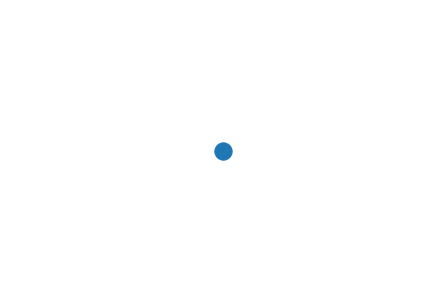

In [18]:
nx.draw(gen_planar_graph(1, generate_sensical_proportions()))

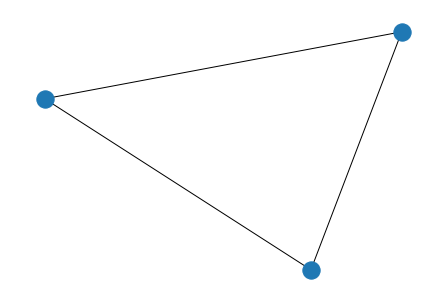

In [19]:
nx.draw(gen_planar_graph(3, generate_sensical_proportions()))

In [20]:
print(assign_across_categories(np.array([0.75, 0.25]),np.array([0.5,0.3,0.2])))

[[0.42667215 0.07332785]
 [0.25323799 0.04676201]
 [0.07008986 0.12991014]]


[[0.32475865 0.32006395 0.0046947  0.22430615 0.08199981 0.01845268]
 [0.3534225  0.35045398 0.00296853 0.12632784 0.20461918 0.02247548]
 [0.32181885 0.28506267 0.03675618 0.07279677 0.19745119 0.0515709 ]]
76 62


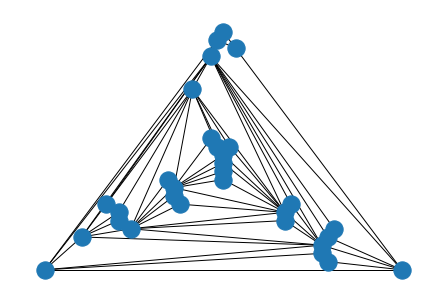

In [21]:
gr = generate_planar_graphs(assign_total_between_buckets(3, 200), generate_sensical_proportions())[0]
nx.draw(gr,pos=nx.planar_layout(gr))
print(gr.number_of_edges(), 2* gr.number_of_nodes())
assert gr.number_of_edges() >= 1.8* gr.number_of_nodes() #this is not guaranteed, but as long as it is happening more often than not, some error is tolerable

In [22]:
assert len(assign_percent_between_buckets(10, 1)) == 10
assert sum(assign_percent_between_buckets(20, 1)) == 1 #this might not always work due to floating-point arithmetic; try again if it fails

In [23]:
print(assign_percent_between_buckets(10, 1))

[0.8701327573751941, 1.6490286884328908e-05, 0.008276234548433079, 0.0014337599410949768, 3.138322733856935e-06, 0.006749704786683583, 0.0007377879330354536, 0.11224060433012743, 4.939440213408799e-05, 0.0003601280736790679]


In [24]:
pop_assignment = sum(assign_population_evenly(10, 1, 0.1))
print(pop_assignment)
assert pop_assignment == 1 #again, might go wrong due to floating point; just try again

1.0


In [30]:
props = generate_sensical_proportions()
print(district_proportions(generate_planar_graphs(assign_total_between_buckets(3, 200), props)[0]), props)

[[0.30687536 0.05822627 0.24864909 0.08405484 0.14521822 0.0776023 ]
 [0.35387987 0.0528919  0.30098797 0.14655084 0.11504804 0.09228099]
 [0.33924476 0.01659512 0.32264964 0.17961168 0.10497508 0.05465801]]
[0.30687536 0.05822627 0.24864909 0.08405484 0.14521822 0.0776023 ] [1.         0.1277133  0.8722867  0.41021737 0.36524134 0.2245413 ]


In [31]:
print(generate_sensical_proportions())
prop = generate_sensical_proportions()
assert prop[0] == 1 #the population; this proportion should always be 1
for bin in BINARY_FIELDS:
  assert prop[bin] > 0 and prop[bin] < 1 #these proportions can be anything as long as they are valid proportions
for group in TERNARY_FIELDS:
  assert sum(prop[np.array(group)]) == 1 #these proportions can be anything but must sum together in a sensical way

[1.         0.03144898 0.96855102 0.04284333 0.05555997 0.9015967 ]


In [32]:
precinct_numbers = assign_total_between_buckets(20,300)

In [33]:
all_districts = generate_planar_graphs(precinct_numbers, generate_sensical_proportions())

[[0.04561226 0.01065216 0.0349601  0.00656195 0.00944257 0.02960774]
 [0.04986637 0.02631162 0.02355475 0.01055242 0.0305705  0.00874346]
 [0.04950058 0.04081831 0.00868228 0.00615756 0.02245306 0.02088996]
 [0.04967373 0.040782   0.00889172 0.00159745 0.00111842 0.04695785]
 [0.04962614 0.02973324 0.01989289 0.00157699 0.00093072 0.04711842]
 [0.0470476  0.0272733  0.01977431 0.00607081 0.03204991 0.00892687]
 [0.04899754 0.00258688 0.04641066 0.00332067 0.00065497 0.0450219 ]
 [0.05217744 0.02838107 0.02379637 0.00068935 0.00655828 0.04492981]
 [0.05242068 0.01008941 0.04233127 0.00419237 0.00573002 0.0424983 ]
 [0.04959322 0.03880306 0.01079016 0.00588908 0.01711098 0.02659316]
 [0.05396189 0.0343229  0.01963899 0.00344992 0.02240712 0.02810485]
 [0.05443817 0.03804987 0.0163883  0.00121364 0.00941655 0.04380798]
 [0.05110238 0.05068457 0.00041781 0.00128239 0.02145518 0.02836481]
 [0.04702652 0.02626506 0.02076146 0.00253066 0.03098383 0.01351203]
 [0.05091434 0.00732183 0.04359252

TypeError: ignored

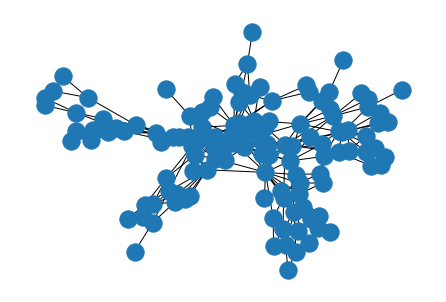

In [36]:
full_graph = glue_graphs2(all_districts) #there are lots of problems with this method, it will not work

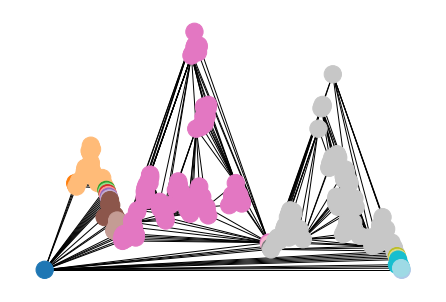

In [41]:
import matplotlib.pyplot as plt
full_graph = glue_graphs_together(all_districts)
districts = [full_graph.nodes[node]['label'] for node in full_graph.nodes()]
color_map = [plt.cm.tab20(i) for i in districts]
nx.draw_planar(full_graph, node_color=color_map)

In [42]:
props = generate_sensical_proportions()
print(props)
np.set_printoptions(suppress=True)
print(majority_outcomes(full_graph, props))

[1.         0.10281609 0.89718391 0.06484018 0.41095525 0.52420457]
[[0.04561226 0.01065216 0.0349601  0.00656195 0.00944257 0.02960774]
 [0.04986637 0.02631162 0.02355475 0.01055242 0.0305705  0.00874346]
 [0.04950058 0.04081831 0.00868228 0.00615756 0.02245306 0.02088996]
 [0.04967373 0.040782   0.00889172 0.00159745 0.00111842 0.04695785]
 [0.04962614 0.02973324 0.01989289 0.00157699 0.00093072 0.04711842]
 [0.0470476  0.0272733  0.01977431 0.00607081 0.03204991 0.00892687]
 [0.04899754 0.00258688 0.04641066 0.00332067 0.00065497 0.0450219 ]
 [0.05217744 0.02838107 0.02379637 0.00068935 0.00655828 0.04492981]
 [0.05242068 0.01008941 0.04233127 0.00419237 0.00573002 0.0424983 ]
 [0.04959322 0.03880306 0.01079016 0.00588908 0.01711098 0.02659316]
 [0.05396189 0.0343229  0.01963899 0.00344992 0.02240712 0.02810485]
 [0.05443817 0.03804987 0.0163883  0.00121364 0.00941655 0.04380798]
 [0.05110238 0.05068457 0.00041781 0.00128239 0.02145518 0.02836481]
 [0.04702652 0.02626506 0.02076146 

# Notes on node data

ALL FIELDS ARE A PERCENTAGE OF STATE TOTAL
- 0: population (the most important and most used field)
- 1: party 1 (assume binary - all of population that is not in party 1 will be in party 2)
- 2: party 2
- 3: race 1
- 4: race 2
- 5: race 3